# Generate embeddings for arbitrary dataset

In [4]:
from yahoo_dataset import YahooDataset

In [67]:
dataset = YahooDataset('./apy/', test = False, auto_crop = True)

In [6]:
import torch
import numpy as np
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from irevnet import iRevNet, iRevNet_ZSL

In [89]:
model = iRevNet_ZSL(nBlocks=[6, 16, 72, 6], nStrides=[2, 2, 2, 2],
                    nChannels=[24, 96, 384, 1536], nClasses=1000, init_ds=2,
                    dropout_rate=0., affineBN=True, in_shape=[3, 224, 224])

model = model.cuda()
model = model.eval()


 == Building iRevNet 301 == 


In [90]:
d = torch.load('irevnet-pretrained.pth.tar')
state_dict = d['state_dict']

from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
    
model.load_state_dict(new_state_dict)

In [9]:
len(dataset)

8999

In [55]:
def pad_and_resize(img, desired_size):

    old_size = img.size  # old_size[0] is in (width, height) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # use thumbnail() or resize() method to resize the input image

    # thumbnail is a in-place operation

    # im.thumbnail(new_size, Image.ANTIALIAS)

    img = img.resize(new_size, Image.ANTIALIAS)
    # create a new image and paste the resized on it

    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(img, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))

    return new_im

# Plot t-SNE embeddings

In [106]:
embeddings = []
names = []

for i in range(300):
    d = dataset[np.random.choice(len(dataset))]
    img = d[0]
    img = pad_and_resize(img, 224)
    
    with torch.no_grad():
        to_tensor = transforms.ToTensor()
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])

        img_in = normalize(to_tensor(img)).unsqueeze(0).cuda()

        features = model.forward_features(img_in)
        
        embeddings.append(features.cpu().data.numpy())
        names.append(d[1])

In [110]:
X = np.array(embeddings).squeeze()

In [112]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(300, 2)

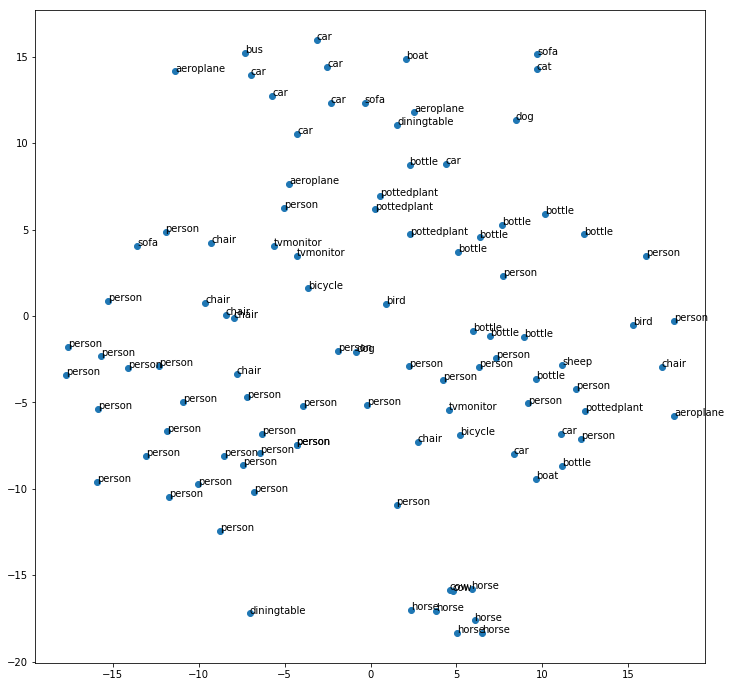

In [124]:
# plt.figure(figsize=(12,12))
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(X_embedded[:100,0], X_embedded[:100,1])

for i, v in enumerate(X_embedded[:100]):
    ax.annotate(names[i], v)